In [ ]:
!pip install gymnasium
!pip install --upgrade pip setuptools
!apt-get install swig

!git clone https://github.com/pybox2d/pybox2d
%cd pybox2d
!python setup.py install


!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 56.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (8,185 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

# Dependencies

In [ ]:
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

import imageio

sns.set_theme()

# Parameters we’ll use

In [ ]:
class Params(NamedTuple):
    total_episodes: int  # le nombre de fois que l'agent va interagir avec l'environnement pour apprendre.
    learning_rate: float  # la vitesse à laquelle l'agent met à jour ses valeurs Q en fonction des nouvelles informations qu'il reçoit.
    gamma: float  # l'importance des récompenses futures par rapport aux récompenses immédiates.
    epsilon: float  # La probabilité d'exploration
    map_size: int  # la taille de la grille
    seed: int  #  Valeur de la graine utilisée pour la génération de nombres aléatoires
    is_slippery: bool  # si l'environnement est glissant ou non
    n_runs: int  # Le nombre d'itérations
    action_size: int  # Le nombre d'actions possibles
    state_size: int  # Le nombre d'états possibles
    proba_frozen: float  # La probabilité qu'une tuile dans l'environnement soit gelée
    savefig_folder: Path


params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("../../_static/img/tutorials/"),
)
params

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exists
params.savefig_folder.mkdir(parents=True, exist_ok=True)

# The FrozenLake environment

In [ ]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

# Creating the Q-table

In [ ]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

Action size: 4
State size: 25


# Running the environment

In [ ]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [ ]:
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

# Visualization

## Processing Simulation Results

In [ ]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

## Mapping Q-table Directions

In [ ]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

## Visualizing Q-values and Policy

In [ ]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

##Analyzing States and Actions Distribution

In [ ]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

##Creating Animated GIF of Environment Episodes

In [ ]:
def create_gif(env, learner, explorer, map_size=5, num_episodes=100):
    all_frames = []

    for _ in range(num_episodes):
        state = env.reset(seed=params.seed)[0]
        done = False
        frames = []

        while not done:
            action = explorer.choose_action(
                action_space=env.action_space, state=state, qtable=learner.qtable
            )
            new_state, _, done, _, _ = env.step(action)
            frames.append(env.render())
            state = new_state

        all_frames.extend(frames)

    imageio.mimsave(f'../../_static/img/tutorials/frozenlake_{map_size}x{map_size}_gif.gif', all_frames, fps=5)


##Exploring Different Map Sizes: Simulation and Visualization

Map size: 4x4


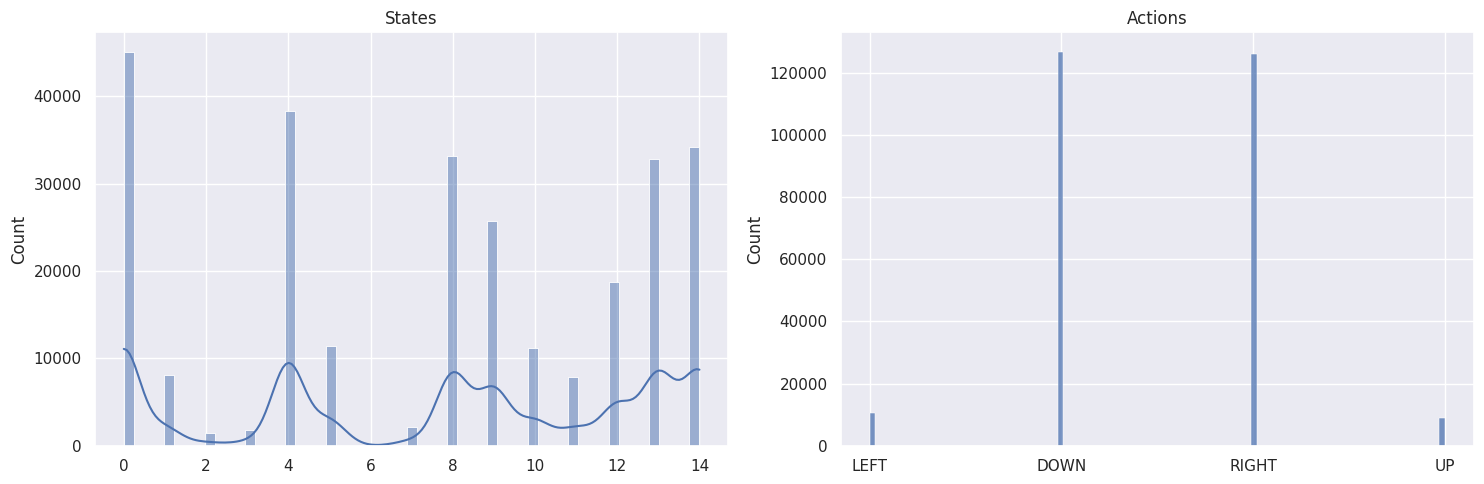

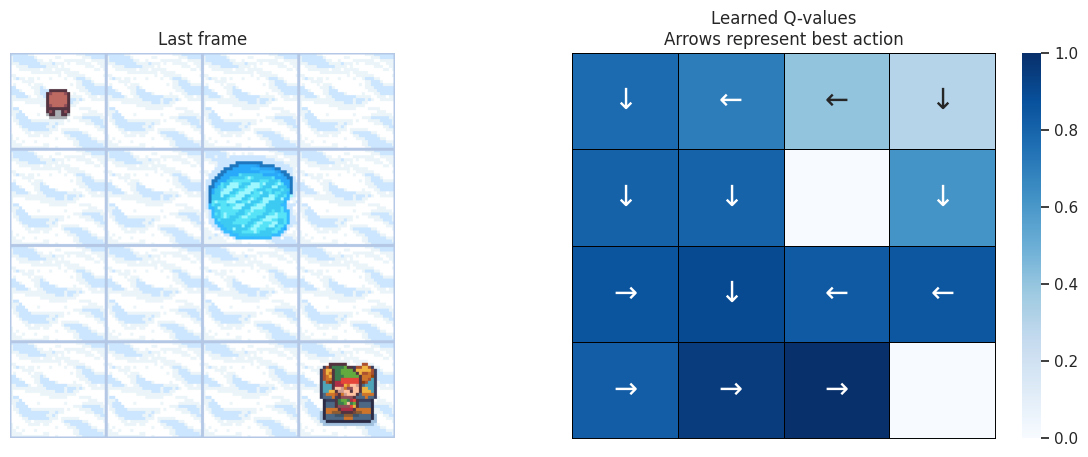

Map size: 7x7


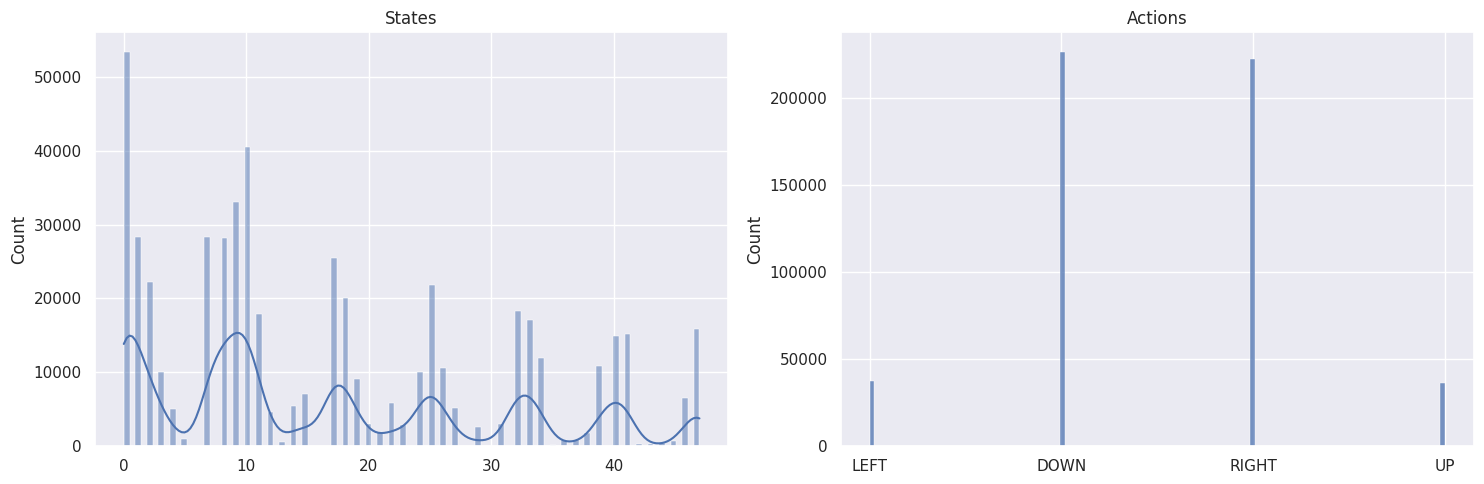

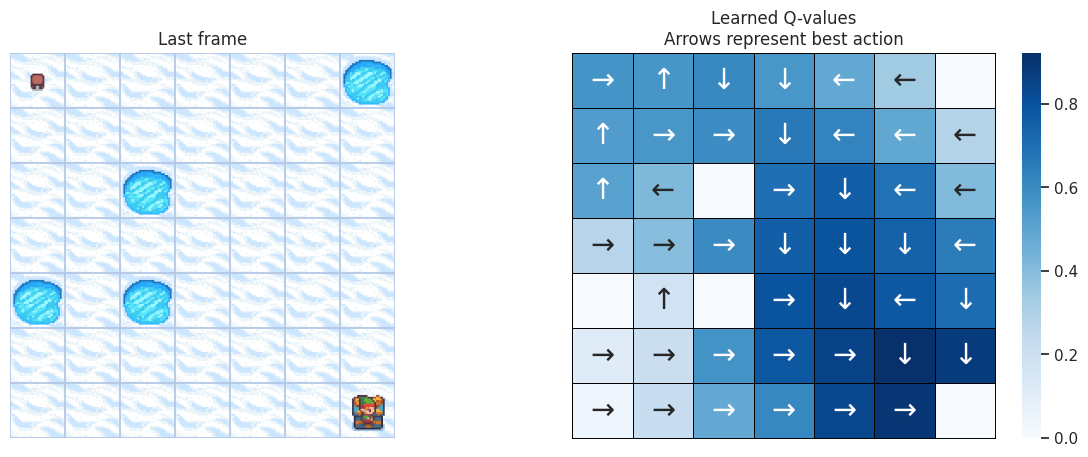

Map size: 9x9


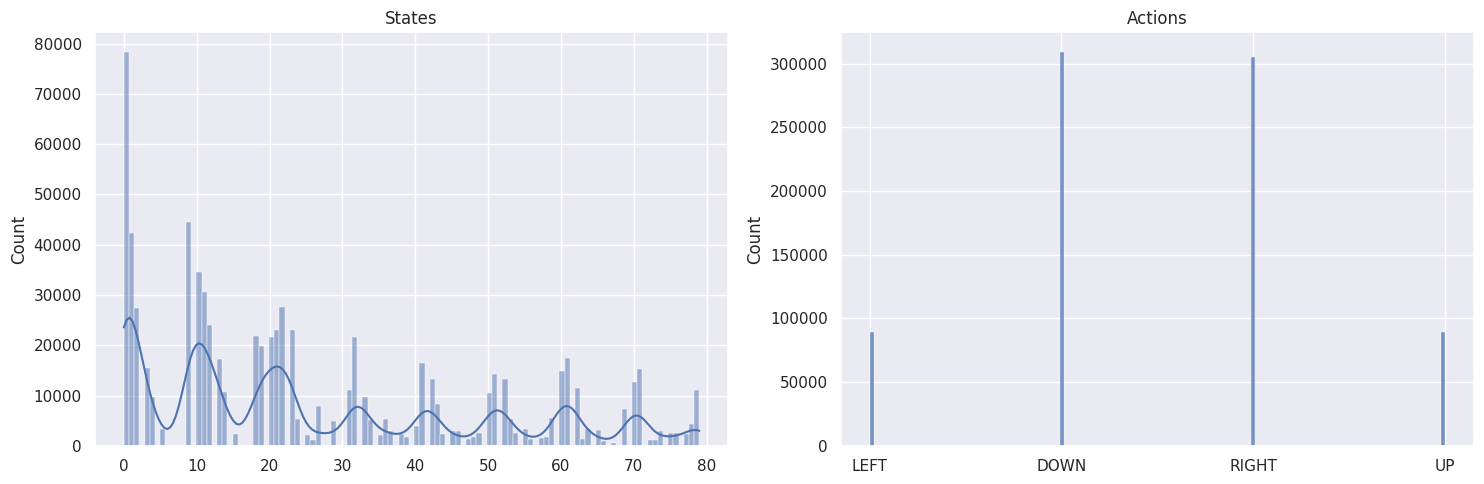

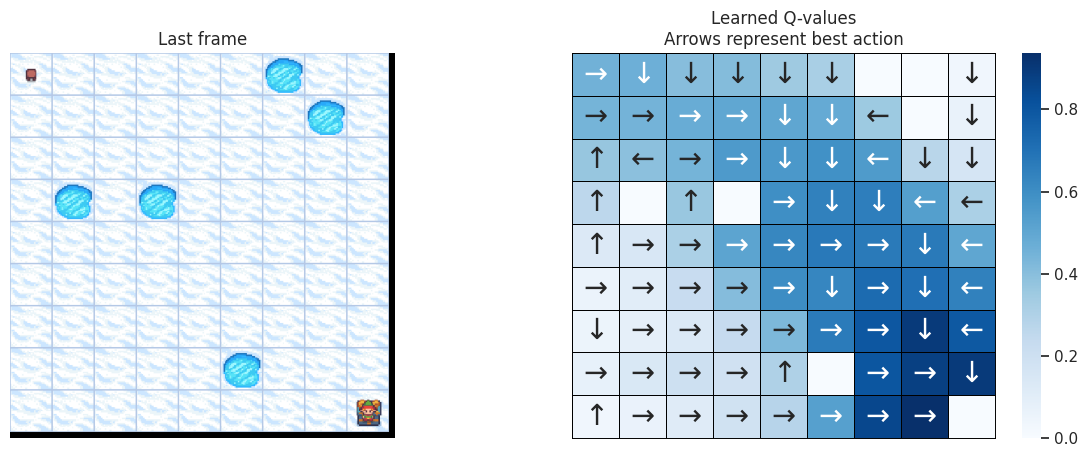

Map size: 11x11


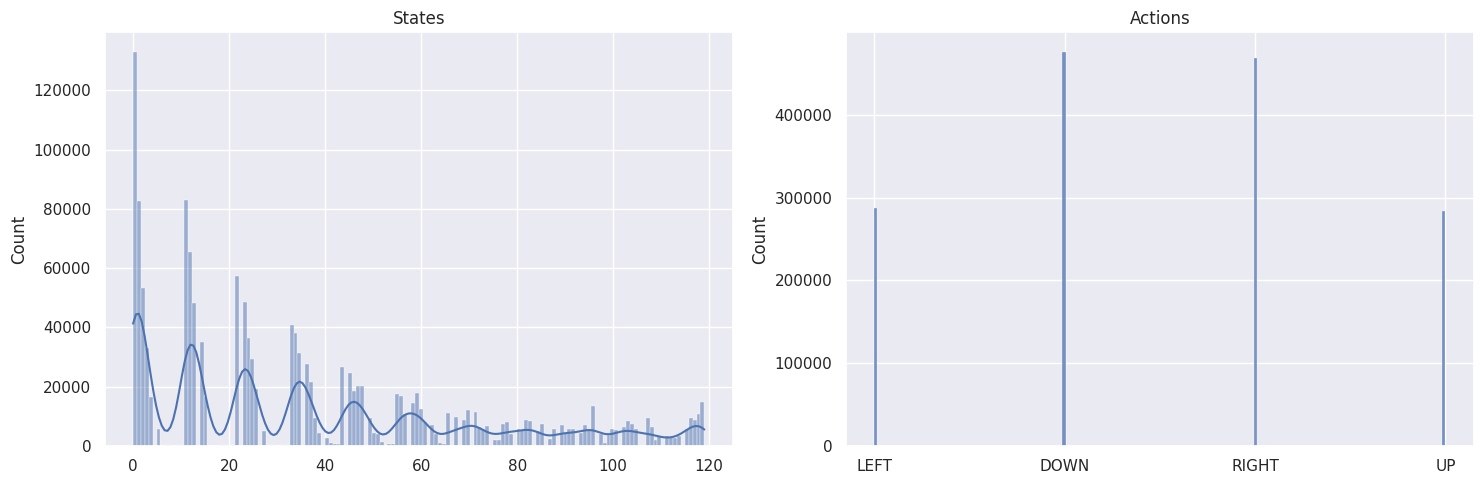

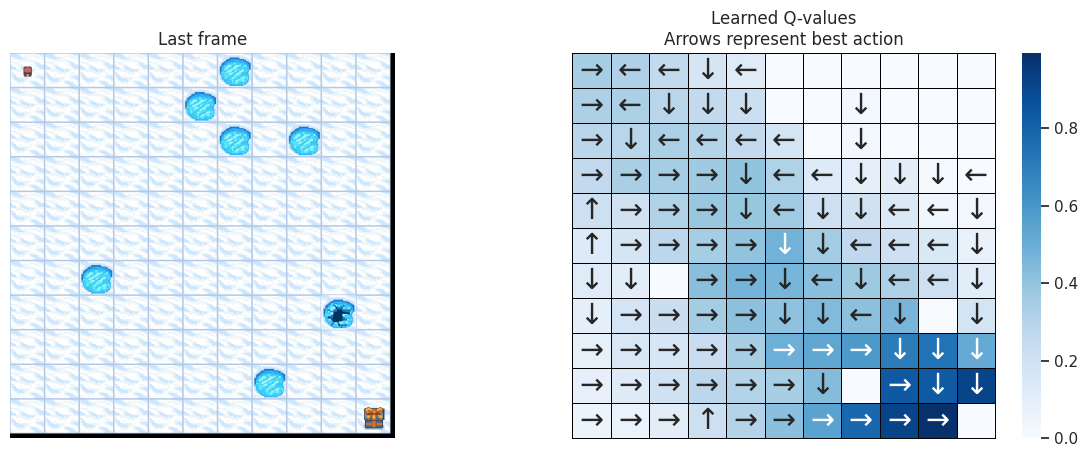

In [ ]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    create_gif(env, learner, explorer, map_size, num_episodes=20)

    env.close()

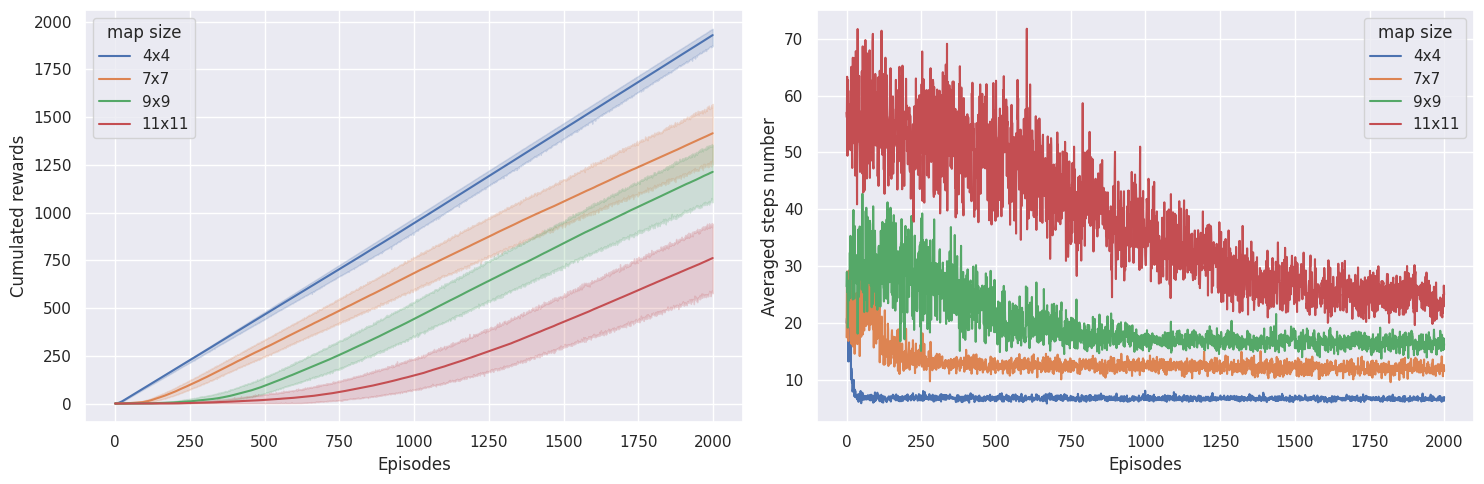

In [ ]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)

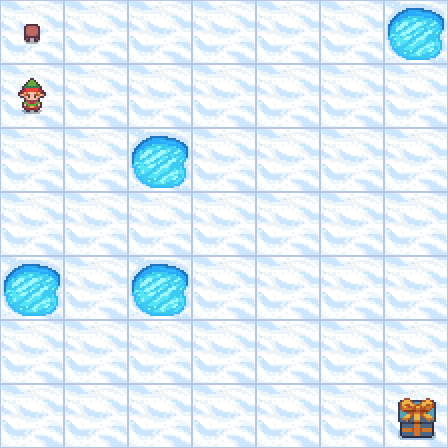

In [ ]:
import imageio

# Load the GIF
gif_path = "../../_static/img/tutorials/frozenlake_7x7_gif.gif"
gif = imageio.mimread(gif_path)

# Display the GIF
imageio.mimwrite('temp.gif', gif) # save as temp.gif
from IPython.display import Image
Image(filename="temp.gif") #display the gif

In [ ]:
imageio.Image("frozenlake_7x7_gif.gif")

AttributeError: module 'imageio' has no attribute 'Image'

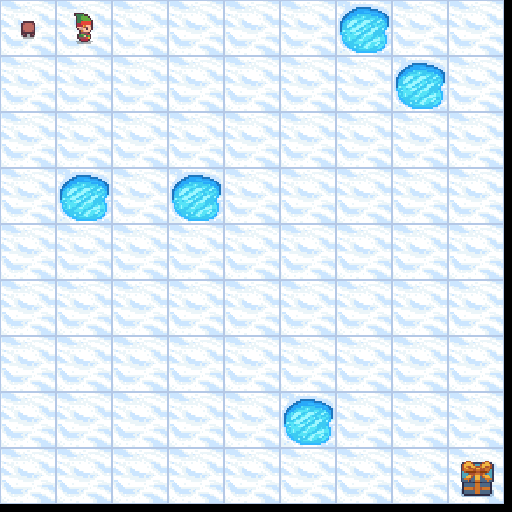

In [ ]:
Image("frozenlake_9x9_gif.gif")

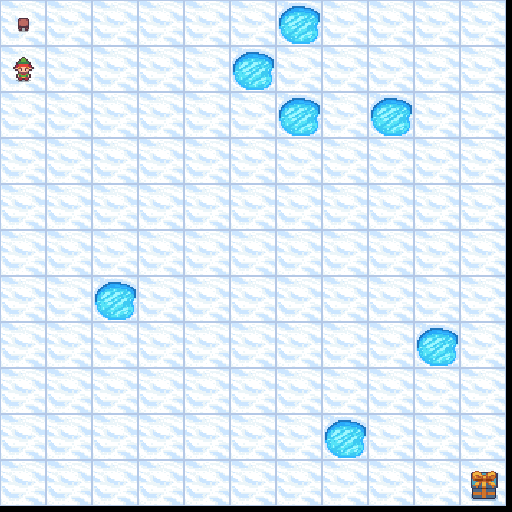

In [ ]:
Image("frozenlake_11x11_gif.gif")

![../../_static/img/tutorials/frozenlake_4x4_gif.gif]
